In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

You should consider upgrading via the 'C:\Users\82104\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")

전처리 

In [4]:
df['BE5_1'] = df['BE5_1'].astype(str).str.strip().replace({ #1주일간 근력운동 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['BE5_1'] = pd.to_numeric(df['BE5_1'], errors='coerce')

In [5]:
df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'1.0' : 1095,
'2.0' : 730,
'3.0' : 365,
'4.0' : 286,
'5.0' : 156,
'6.0' : 52,
'7.0' : 30,
'8.0' : 12,
'9.0' : 6,
'99.0': np.nan,
'nan' : np.nan
})
df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')

In [6]:

# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')


In [7]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주 빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 286,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [8]:
df['L_OUT_FQ'] = df['L_OUT_FQ'].astype(str).str.strip().replace({ #최근 1년 동안 평균 외식 끼니 수 (365일, 하루3끼 기준)
'1.0' : 912.5,
'2.0' : 365,
'3.0' : 286,
'4.0' : 182,
'5.0' : 78,
'6.0' : 24,
'7.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['L_OUT_FQ'] = pd.to_numeric(df['L_OUT_FQ'], errors='coerce')

고혈압 

In [9]:
# HE_HP 결측치 행 제거
df_clustering = df.dropna(subset=['HE_HP'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE5_1','BD1_11', 'LS_VEG1', 'tobacco', 'L_OUT_FQ'
]

In [10]:

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE5_1       847
BD1_11      160
LS_VEG1     421
tobacco     173
L_OUT_FQ    418
dtype: int64
------------------------------

Processing column: 'BE5_1'
  NaN count before filling: 847
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 847 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 160
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 160 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'LS_VEG1'
  NaN count before filling: 421
  Calculated mode value: 730.0 (Type: <class 'numpy.float64'>)
  Filled 421 NaN values with 730.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 173
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 173 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'L_OUT_FQ'
  NaN count before fillin

In [11]:
knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_HP별로 데이터 분리 및 KNN Imputation
for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][knn_columns].copy()
    if not hp_df.empty:
        # 비해당/모름 값 NaN으로 변환
        hp_df = hp_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        hp_imputed = imputer.fit_transform(hp_df)
        hp_imputed_df = pd.DataFrame(hp_imputed, columns=knn_columns, index=hp_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[hp_df.index, knn_columns] = hp_imputed_df


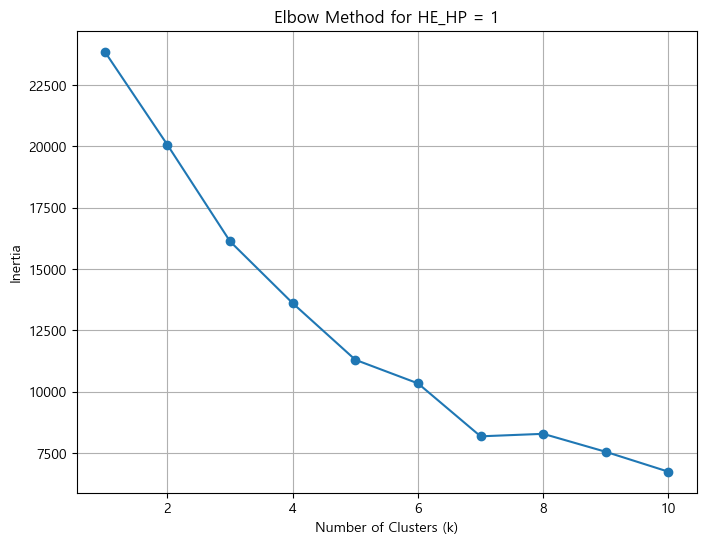

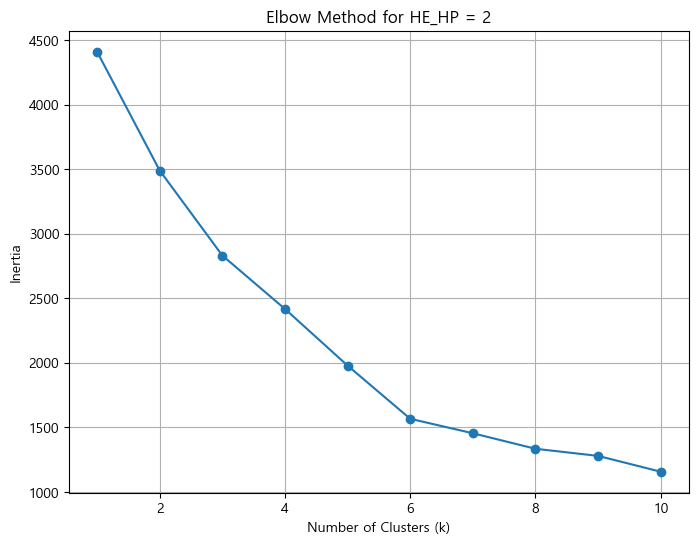

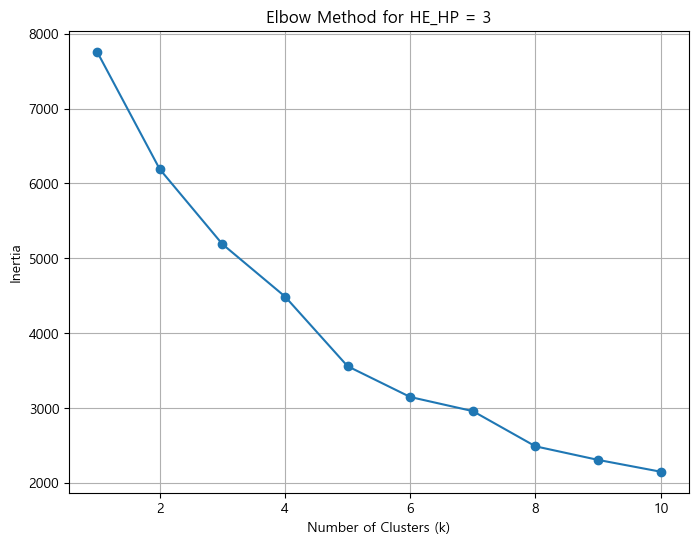

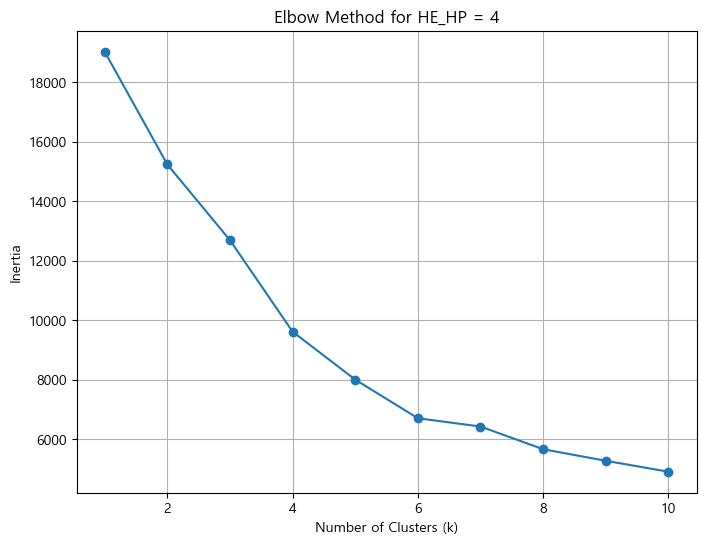

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (예: 1~10)
k_range = range(1, 11)

# 결과를 저장할 데이터프레임 준비
df_clustering['Cluster'] = np.nan

#selected_cols = knn_columns + ["BD1_11","tobacco","BE5_1","LS_VEG1"]
selected_cols = ['BE5_1','BD1_11', 'LS_VEG1', 'tobacco', 'L_OUT_FQ']
#selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc','HE_BMI','HE_glu', "BD1_11","tobacco","BE5_1","LS_VEG1"]

for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()

    if not hp_df.empty:
        # 데이터 표준화
        scaled_df = scaler.fit_transform(hp_df)

        # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산
        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()

        # 최적 k 선택 (예: 관성 감소율 기반)
        # 여기서는 수동으로 플롯을 보고 k를 선택하거나, 자동화된 방법을 사용할 수 있음
        # 예: 관성 감소율이 완만해지는 k를 선택 (임시로 k=3으로 설정, 실제로는 플롯 확인 후 결정)
        optimal_k = 3  # TODO: 엘보우 플롯을 보고 직접 선택하거나 자동화 필요

        # 최적 k로 K-means 군집화 수행
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(scaled_df)

        # 클러스터 결과 저장
        df_clustering.loc[hp_df.index, 'Cluster'] = clusters


--- Processing HE_HP = 1 with k = 5 ---
Silhouette Score for HE_HP = 1 (k=5): 0.3582
Cluster Characteristics (Mean values for HE_HP = 1, k=5):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               0.499072  167.914657          736.528757   2.486085   
1               0.056287   14.346491          797.960526   0.306652   
2               0.584046   43.863248          718.022792  18.749288   
3               3.577523   24.767950          804.836629   0.620187   
4               0.940541   47.989189          807.362162   2.572973   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     197.482375  
1                     160.833699  
2                     207.797721  
3                     170.850156  
4                     912.500000  
------------------------------------------------------------


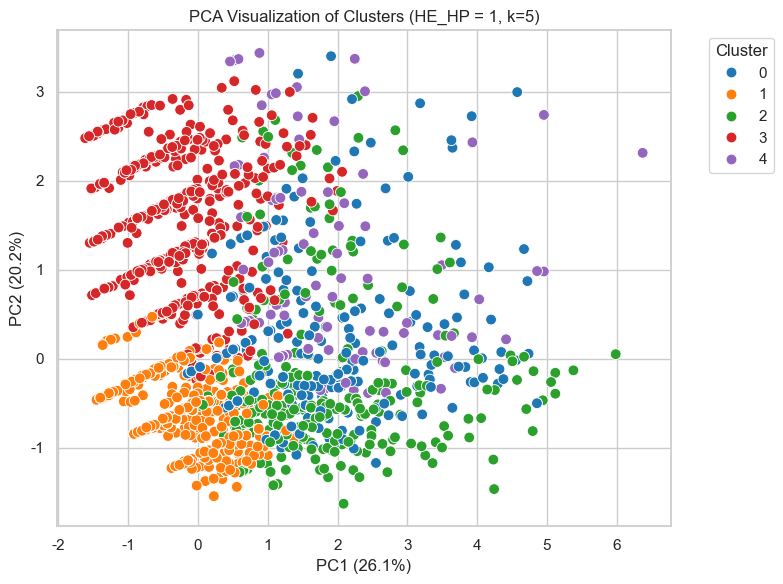


--- Processing HE_HP = 2 with k = 3 ---
Silhouette Score for HE_HP = 2 (k=3): 0.3675
Cluster Characteristics (Mean values for HE_HP = 2, k=3):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도  하루평균 흡연량  \
New_Cluster                                                          
0               0.160777   15.978799          882.966431  0.190813   
1               4.191083   38.598726          905.356688  2.095541   
2               0.358491  120.968553          757.603774  9.955975   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     113.563604  
1                     163.429936  
2                     345.147799  
------------------------------------------------------------


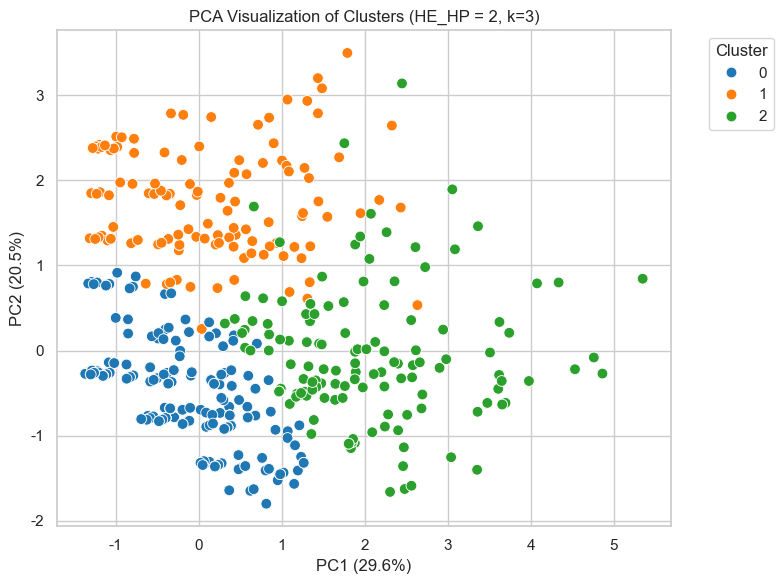


--- Processing HE_HP = 3 with k = 5 ---
Silhouette Score for HE_HP = 3 (k=5): 0.3244
Cluster Characteristics (Mean values for HE_HP = 3, k=5):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               0.234295   36.125637          658.682513   0.874363   
1               0.704918   76.491803          852.229508   6.295082   
2               4.248945   47.451477          885.540084   1.232068   
3               0.374502  170.884462          789.410359  14.091633   
4               0.164251   28.236715         1095.000000   0.456522   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     168.889643  
1                     912.500000  
2                     160.683544  
3                     208.673307  
4                     125.751208  
------------------------------------------------------------


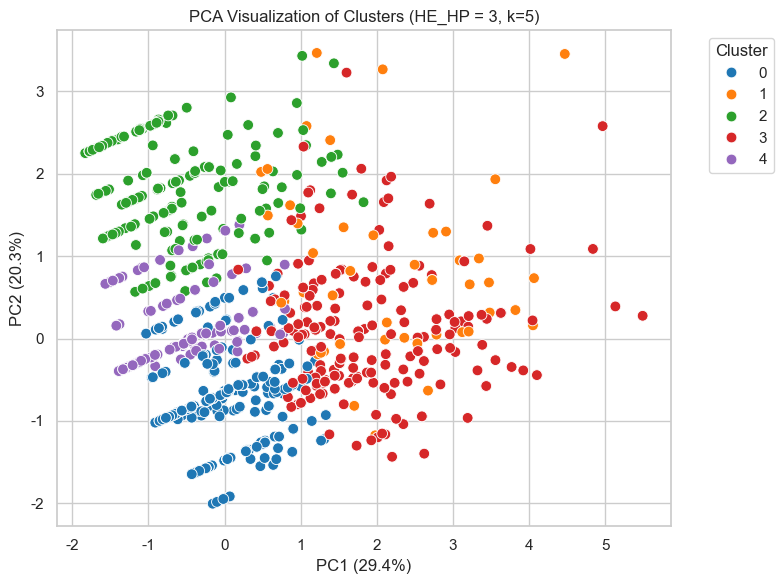


--- Processing HE_HP = 4 with k = 4 ---
Silhouette Score for HE_HP = 4 (k=4): 0.3936
Cluster Characteristics (Mean values for HE_HP = 4, k=4):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               0.137288   24.133898          668.144068   0.772881   
1               4.419708   48.543796          953.129562   0.812044   
2               0.073953   18.541885         1095.000000   0.340314   
3               0.478976  191.590494          878.226691  12.206581   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     122.051271  
1                     121.576642  
2                      90.528141  
3                     249.121572  
------------------------------------------------------------


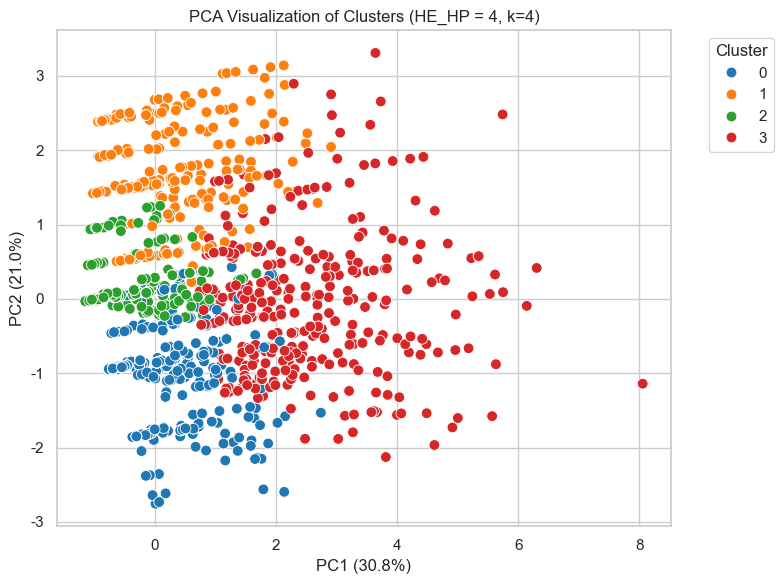

In [13]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd # pandas 필요
import matplotlib.pyplot as plt # matplotlib 필요
from sklearn.cluster import KMeans # KMeans 필요
# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
from sklearn.metrics import silhouette_score


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량',
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도',
    'L_OUT_FQ' : '최근 1년 동안 평균 외식 끼니 수',
    'BP1': '평소 스트레스 인지 정도',
    'sleep': '하루 평균 수면시간'
}

# 시각화용 설정
sns.set(style="whitegrid")

# HE_HP 별로 반복
for hp_value, optimal_k in zip([1, 2, 3, 4], [5, 3, 5, 4]):
    print(f"\n--- Processing HE_HP = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함 (예: selected_cols = ['HE_sbp1', '...', 'LS_VEG1'])
    # df_clustering는 이전에 로드/처리되어 있어야 함
    # scaler는 이전에 fit 되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()
    # 이 변수는 현재 코드 플로우에서 직접 사용되지 않습니다. (기존 클러스터 라벨)
    # cluster_labels = df_clustering[df_clustering['HE_HP'] == hp_value]['Cluster']


    if not hp_df.empty:
        # 표준화
        scaled_df = scaler.fit_transform(hp_df)

        # ====== 여기에서 optimal_k 값을 사용하여 클러스터링 수행 ======
        # K-Means 예시
        # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        if optimal_k > 1 and scaled_df.shape[0] > 1: # 데이터 포인트가 1개보다 많아야 계산 가능
                silhouette_avg = silhouette_score(scaled_df, new_cluster_labels)
                print(f"Silhouette Score for HE_HP = {hp_value} (k={optimal_k}): {silhouette_avg:.4f}")
        else:
            if optimal_k <= 1:
                print(f"Silhouette Score cannot be calculated for k = {optimal_k} (must be > 1).")
            else: # scaled_df.shape[0] <= 1
                 print(f"Silhouette Score cannot be calculated for HE_HP = {hp_value}: Insufficient data points ({scaled_df.shape[0]}).")

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 새로 생성된 클러스터 라벨 추가
        # 인덱스가 맞아야 함 (위에서 같은 필터링 기준으로 슬라이싱했으므로 일치한다고 가정)
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = new_cluster_labels

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP = {hp_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 new_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = new_cluster_labels

        # PCA 2차원 축소
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df)

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 새로 생성된 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        plt.title(f'PCA Visualization of Clusters (HE_HP = {hp_value}, k={optimal_k})') # 제목에 k값 추가
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


--- Processing HE_HP = 1 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.3145
  - Agglomerative: Silhouette Score = 0.2676
  - MiniBatchKMeans: Silhouette Score = 0.2822

Best algorithm for HE_HP = 1 (k=5): KMeans (Silhouette Score: 0.3145)
Cluster Characteristics (Mean values for HE_HP = 1, k=5):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               0.186888   12.105675         1095.000000   0.367906   
1               4.094541   27.299601          814.105193   0.764314   
2               0.503534  167.759717          739.717314   2.469965   
3               0.631922   51.315961          743.996743  20.400651   
4               0.232832   16.111947          647.918627   0.574318   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     161.686399  
1                     196.815579  
2                     233.0653

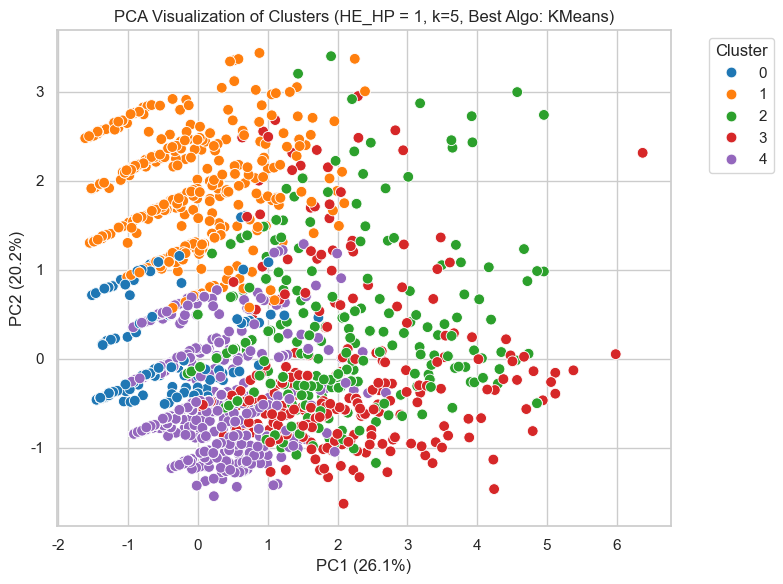


--- Processing HE_HP = 2 with k = 3 ---
Comparing algorithms for k = 3:
  - KMeans: Silhouette Score = 0.3674
  - Agglomerative: Silhouette Score = 0.3423
  - MiniBatchKMeans: Silhouette Score = 0.2750

Best algorithm for HE_HP = 2 (k=3): KMeans (Silhouette Score: 0.3674)
Cluster Characteristics (Mean values for HE_HP = 2, k=3):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도  하루평균 흡연량  \
New_Cluster                                                          
0               0.165468   14.942446          890.969424  0.152878   
1               0.285714  118.273810          740.916667  9.285714   
2               4.215190   38.987342          901.936709  2.373418   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     111.674460  
1                     338.116071  
2                     164.047468  
------------------------------------------------------------


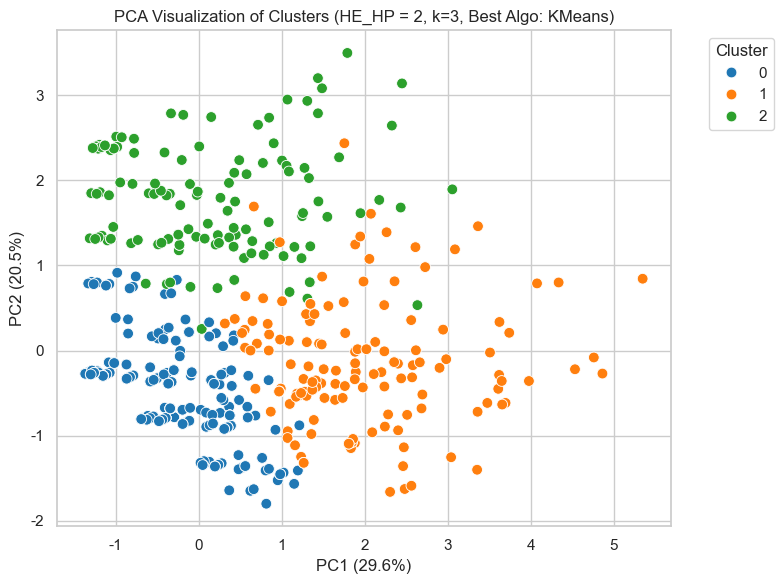


--- Processing HE_HP = 3 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.3158
  - Agglomerative: Silhouette Score = 0.2524
  - MiniBatchKMeans: Silhouette Score = 0.3245

Best algorithm for HE_HP = 3 (k=5): MiniBatchKMeans (Silhouette Score: 0.3245)
Cluster Characteristics (Mean values for HE_HP = 3, k=5):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               0.235094   36.228279          658.439523   0.826235   
1               0.704918   76.491803          852.229508   6.295082   
2               4.248945   47.451477          885.540084   1.232068   
3               0.371542  169.581028          788.940711  14.098814   
4               0.164251   28.236715         1095.000000   0.456522   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     169.199319  
1                     912.500000  
2                    

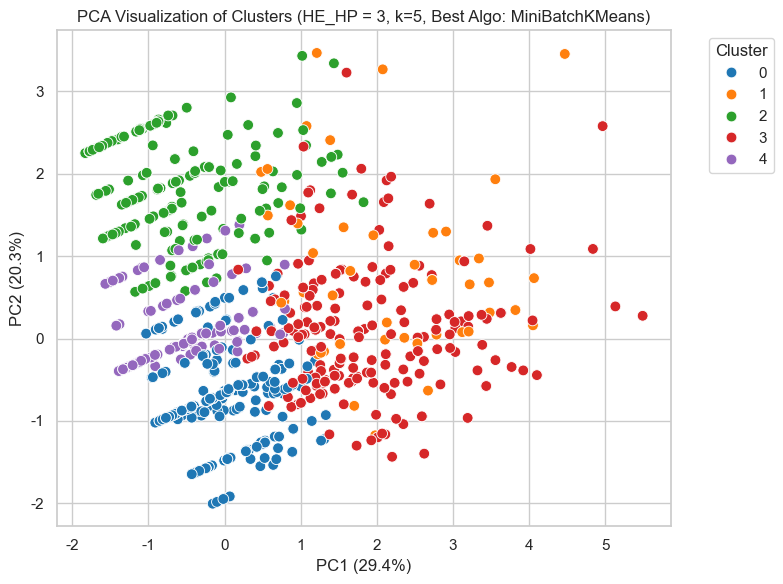


--- Processing HE_HP = 4 with k = 4 ---
Comparing algorithms for k = 4:
  - KMeans: Silhouette Score = 0.3820
  - Agglomerative: Silhouette Score = 0.3480
  - MiniBatchKMeans: Silhouette Score = 0.3883

Best algorithm for HE_HP = 4 (k=4): MiniBatchKMeans (Silhouette Score: 0.3883)
Cluster Characteristics (Mean values for HE_HP = 4, k=4):
             1주일 간 운동 횟수  1년 간 음주 빈도  1년 동안 평균 채소류 섭취 빈도   하루평균 흡연량  \
New_Cluster                                                           
0               4.392540   54.479574          952.371226   0.976909   
1               0.132231   33.294215          666.940496   0.796694   
2               0.072519   29.922392         1095.000000   0.353690   
3               0.462882  153.310044          872.820961  14.157205   

             최근 1년 동안 평균 외식 끼니 수  
New_Cluster                       
0                     118.635879  
1                     110.727686  
2                      76.944020  
3                     357.014192  
----------------------

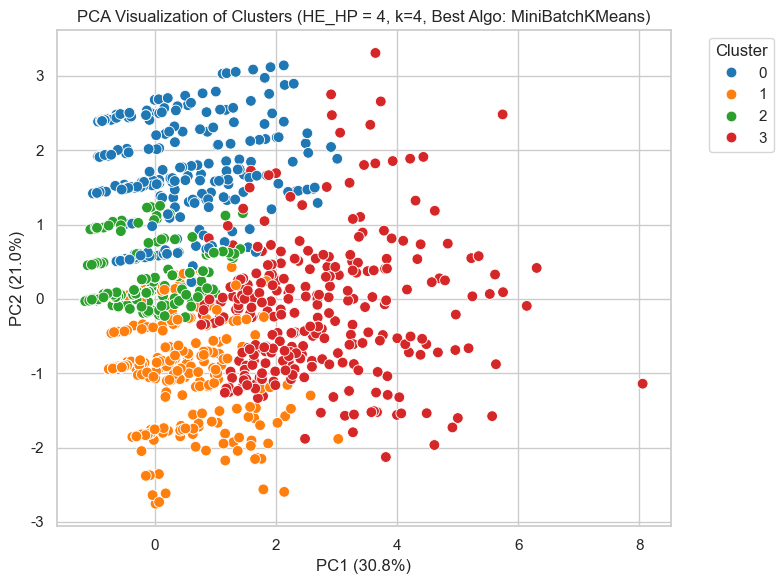


--- Processing complete ---


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량', # 이 피처가 selected_cols에 있는지 확인 필요
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도',
    'L_OUT_FQ' : '최근 1년 동안 평균 외식 끼니 수',
    'BP1': '평소 스트레스 인지 정도',
    'sleep': '하루 평균 수면시간'
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1', 'age', 'sex', 'HE_HbA1c'] # 실제 selected_cols 목록
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}


# HE_HP 별로 반복
# optimal_k 리스트는 각 HE_HP 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [3, 5, 5, 5]
# HE_HP_values = [1, 2, 3, 4] # 실제 HE_HP 고유값
# for hp_value, optimal_k in zip(HE_HP_values, optimal_k_list):

for hp_value, optimal_k in zip([1, 2, 3, 4], [5, 3, 5, 4]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_HP = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()

    if not hp_df.empty:
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(hp_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f"  - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f"  - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f"  - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_HP = {hp_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_HP = {hp_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP = {hp_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_HP = {hp_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data for HE_HP = {hp_value}")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")


당뇨 

In [130]:
# HE_DM_HbA1c 결측치 행 제거
df_clustering = df.dropna(subset=['HE_DM_HbA1c'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

In [131]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE5_1      769
BD1_11     120
LS_VEG1    412
tobacco      0
dtype: int64
------------------------------

Processing column: 'BE5_1'
  NaN count before filling: 769
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 769 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 120
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 120 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'LS_VEG1'
  NaN count before filling: 412
  Calculated mode value: 730.0 (Type: <class 'numpy.float64'>)
  Filled 412 NaN values with 730.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 0
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  No NaN values found to fill in 'tobacco'.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified colu

In [132]:

knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_DM_HbA1c별로 데이터 분리 및 KNN Imputation
for HE_DM_HbA1c_value in [1, 2, 3]:
    # HE_DM_HbA1c 값에 해당하는 데이터 추출
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c'] == HE_DM_HbA1c_value][knn_columns].copy()
    if not HE_DM_HbA1c_df.empty:
        # 비해당/모름 값 NaN으로 변환
        HE_DM_HbA1c_df = HE_DM_HbA1c_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        HE_DM_HbA1c_imputed = imputer.fit_transform(HE_DM_HbA1c_df)
        HE_DM_HbA1c_imputed_df = pd.DataFrame(HE_DM_HbA1c_imputed, columns=knn_columns, index=HE_DM_HbA1c_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[HE_DM_HbA1c_df.index, knn_columns] = HE_DM_HbA1c_imputed_df


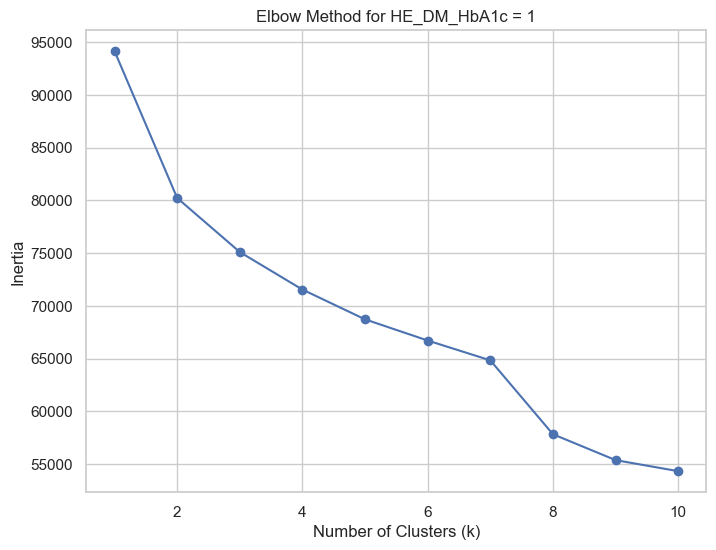

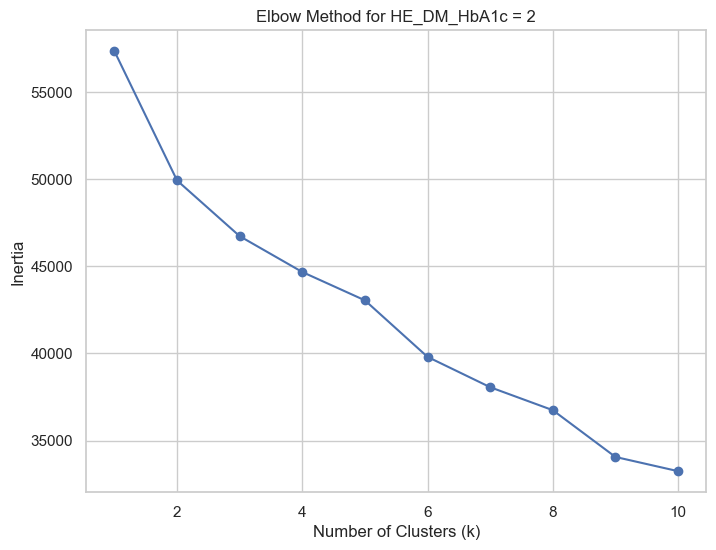

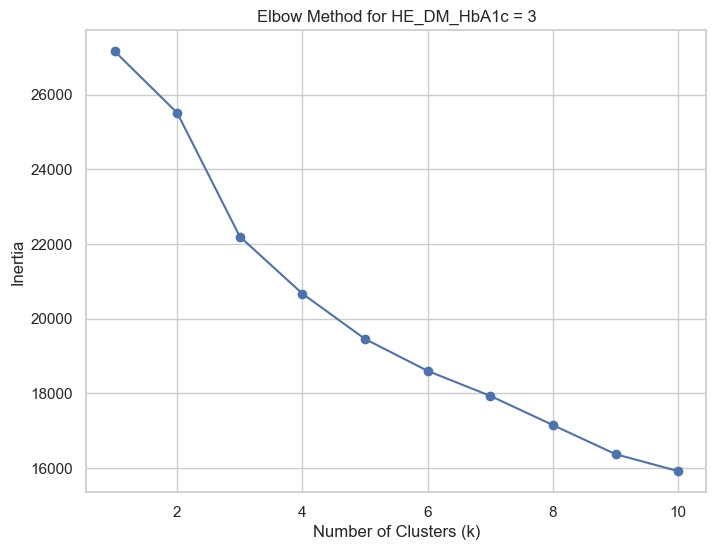

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (예: 1~10)
k_range = range(1, 11)

# 결과를 저장할 데이터프레임 준비
df_clustering['Cluster'] = np.nan

selected_cols = knn_columns + ["BD1_11","tobacco","BE5_1","LS_VEG1"]

for HE_DM_HbA1c_value in [1, 2, 3, 4]:
    # HE_DM_HbA1c 값에 해당하는 데이터 추출
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c'] == HE_DM_HbA1c_value][selected_cols].copy()

    if not HE_DM_HbA1c_df.empty:
        # 데이터 표준화
        scaled_df = scaler.fit_transform(HE_DM_HbA1c_df)

        # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산
        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, inertias, marker='o')
        plt.title(f'Elbow Method for HE_DM_HbA1c = {HE_DM_HbA1c_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()

        # 최적 k 선택 (예: 관성 감소율 기반)
        # 여기서는 수동으로 플롯을 보고 k를 선택하거나, 자동화된 방법을 사용할 수 있음
        # 예: 관성 감소율이 완만해지는 k를 선택 (임시로 k=3으로 설정, 실제로는 플롯 확인 후 결정)
        optimal_k = 3  # TODO: 엘보우 플롯을 보고 직접 선택하거나 자동화 필요

        # 최적 k로 K-means 군집화 수행
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(scaled_df)

        # 클러스터 결과 저장
        df_clustering.loc[HE_DM_HbA1c_df.index, 'Cluster'] = clusters


--- Processing HE_DM_HbA1c = 1 with k = 2 ---
Silhouette Score for HE_DM_HbA1c = 1 (k=2): 0.1654
Cluster Characteristics (Mean values for HE_DM_HbA1c = 1, k=2):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레         혈당     총 콜레스테롤  \
New_Cluster                                                                     
0                125.613987       78.250490  88.989399  91.597868  193.506610   
1                112.224045       70.547464  74.054145  88.831872  188.515654   

             HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  크레아티닌 (신장 기능 지표)  \
New_Cluster                                                                 
0                       52.233689            122.916418          0.869288   
1                       66.298998            112.551033          0.703607   

             AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)         체중           키  \
New_Cluster                                                                  
0                     23.872154           25.412

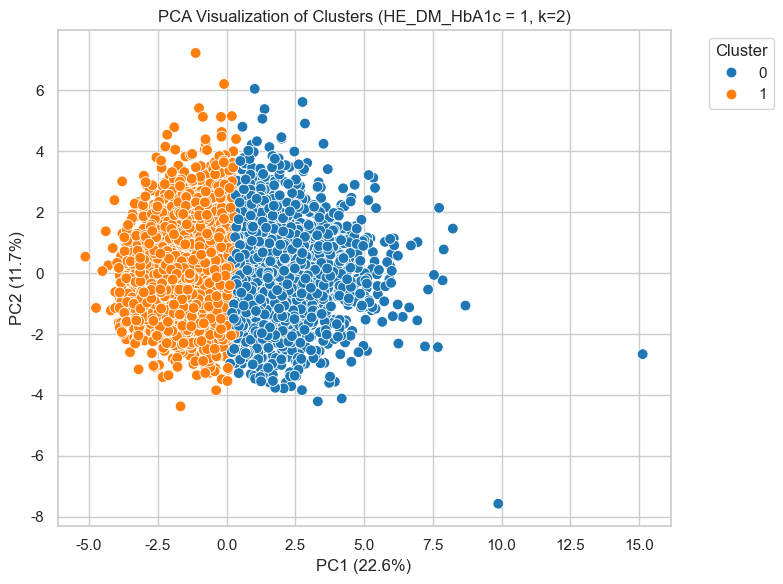


--- Processing HE_DM_HbA1c = 2 with k = 3 ---
Silhouette Score for HE_DM_HbA1c = 2 (k=3): 0.1510
Cluster Characteristics (Mean values for HE_DM_HbA1c = 2, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레          혈당  \
New_Cluster                                                          
0                129.982993       80.962993  94.320871  105.512925   
1                122.229989       74.361273  81.221866  101.716289   
2                130.156000       77.768000  86.684800  103.680000   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            191.826531             49.336054            119.400000   
1            190.296656             59.560949            115.483279   
2            189.320000             51.860000            116.220000   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                               

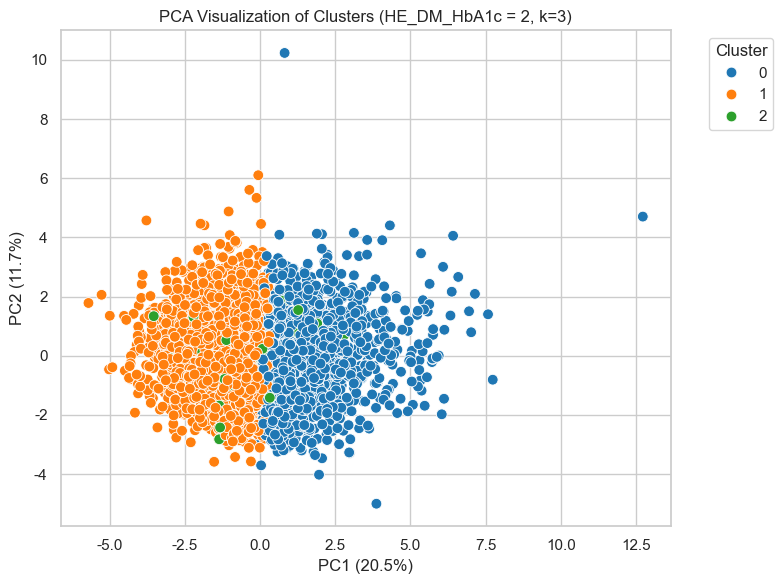


--- Processing HE_DM_HbA1c = 3 with k = 3 ---
Silhouette Score for HE_DM_HbA1c = 3 (k=3): 0.1511
Cluster Characteristics (Mean values for HE_DM_HbA1c = 3, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레          혈당  \
New_Cluster                                                          
0                131.997143       80.329841  97.641048  142.504762   
1                125.633154       72.728525  84.955027  127.503767   
2                135.343590       78.594872  88.765128  143.871795   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            173.433333             47.198413            101.192063   
1            155.287406             53.236814             85.067815   
2            149.897436             50.717949             81.487179   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                               

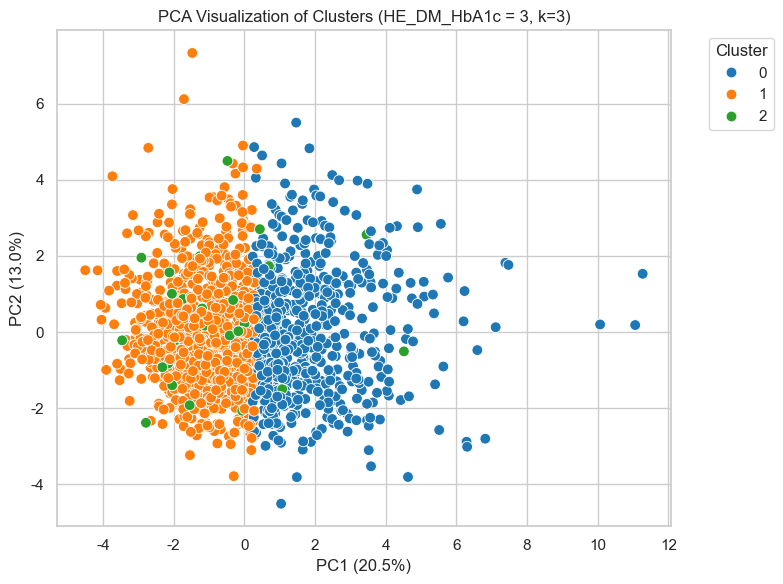

In [134]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd # pandas 필요
import matplotlib.pyplot as plt # matplotlib 필요
from sklearn.cluster import KMeans # KMeans 필요
# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
from sklearn.metrics import silhouette_score


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량',
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도'
}

# 시각화용 설정
sns.set(style="whitegrid")

# HE_DM_HbA1c 별로 반복
for HE_DM_HbA1c_value, optimal_k in zip([1, 2, 3], [2, 3, 3]):
    print(f"\n--- Processing HE_DM_HbA1c = {HE_DM_HbA1c_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함 (예: selected_cols = ['HE_sbp1', '...', 'LS_VEG1'])
    # df_clustering는 이전에 로드/처리되어 있어야 함
    # scaler는 이전에 fit 되어 있어야 함
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c'] == HE_DM_HbA1c_value][selected_cols].copy()
    # 이 변수는 현재 코드 플로우에서 직접 사용되지 않습니다. (기존 클러스터 라벨)
    # cluster_labels = df_clustering[df_clustering['HE_HP'] == hp_value]['Cluster']


    if not HE_DM_HbA1c_df.empty:
        # 표준화
        scaled_df = scaler.fit_transform(HE_DM_HbA1c_df)

        # ====== 여기에서 optimal_k 값을 사용하여 클러스터링 수행 ======
        # K-Means 예시
        # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        if optimal_k > 1 and scaled_df.shape[0] > 1: # 데이터 포인트가 1개보다 많아야 계산 가능
                silhouette_avg = silhouette_score(scaled_df, new_cluster_labels)
                print(f"Silhouette Score for HE_DM_HbA1c = {HE_DM_HbA1c_value} (k={optimal_k}): {silhouette_avg:.4f}")
        else:
            if optimal_k <= 1:
                print(f"Silhouette Score cannot be calculated for k = {optimal_k} (must be > 1).")
            else: # scaled_df.shape[0] <= 1
                 print(f"Silhouette Score cannot be calculated for HE_DM_HbA1c = {HE_DM_HbA1c_value}: Insufficient data points ({scaled_df.shape[0]}).")

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 새로 생성된 클러스터 라벨 추가
        # 인덱스가 맞아야 함 (위에서 같은 필터링 기준으로 슬라이싱했으므로 일치한다고 가정)
        HE_DM_HbA1c_with_labels = HE_DM_HbA1c_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        HE_DM_HbA1c_with_labels['New_Cluster'] = new_cluster_labels

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = HE_DM_HbA1c_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_DM_HbA1c = {HE_DM_HbA1c_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 new_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = new_cluster_labels

        # PCA 2차원 축소
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df)

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 새로 생성된 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        plt.title(f'PCA Visualization of Clusters (HE_DM_HbA1c = {HE_DM_HbA1c_value}, k={optimal_k})') # 제목에 k값 추가
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

비만

In [135]:
# HE_obe 결측치 행 제거
df_clustering = df.dropna(subset=['HE_obe'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

In [136]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE5_1      899
BD1_11     179
LS_VEG1    453
tobacco      0
dtype: int64
------------------------------

Processing column: 'BE5_1'
  NaN count before filling: 899
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 899 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 179
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 179 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'LS_VEG1'
  NaN count before filling: 453
  Calculated mode value: 730.0 (Type: <class 'numpy.float64'>)
  Filled 453 NaN values with 730.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 0
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  No NaN values found to fill in 'tobacco'.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified colu

In [137]:
            
knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_obe별로 데이터 분리 및 KNN Imputation
for HE_obe_value in [1, 2, 3, 4, 5, 6 ]:
    # HE_obe 값에 해당하는 데이터 추출
    HE_obe_df = df_clustering[df_clustering['HE_obe'] == HE_obe_value][knn_columns].copy()
    if not HE_obe_df.empty:
        # 비해당/모름 값 NaN으로 변환
        HE_obe_df = HE_obe_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        HE_obe_imputed = imputer.fit_transform(HE_obe_df)
        HE_obe_imputed_df = pd.DataFrame(HE_obe_imputed, columns=knn_columns, index=HE_obe_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[HE_obe_df.index, knn_columns] =  HE_obe_imputed_df


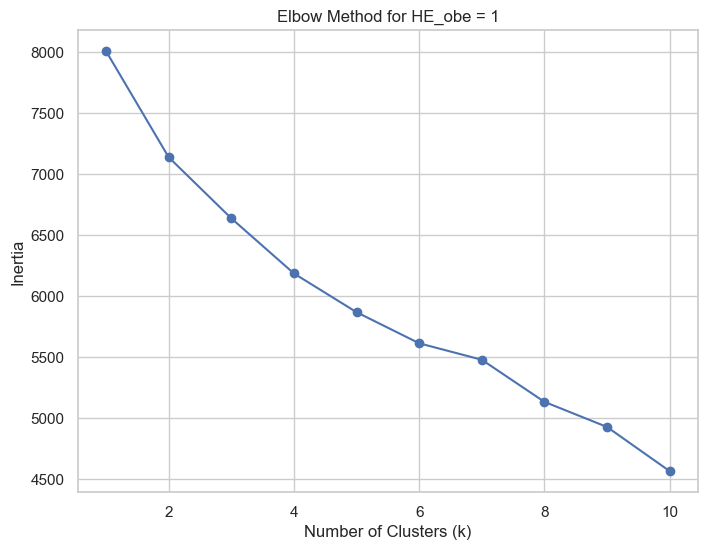

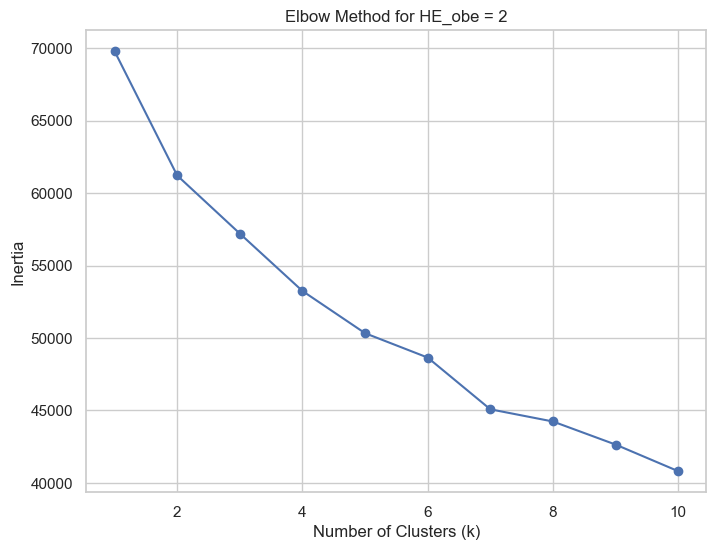

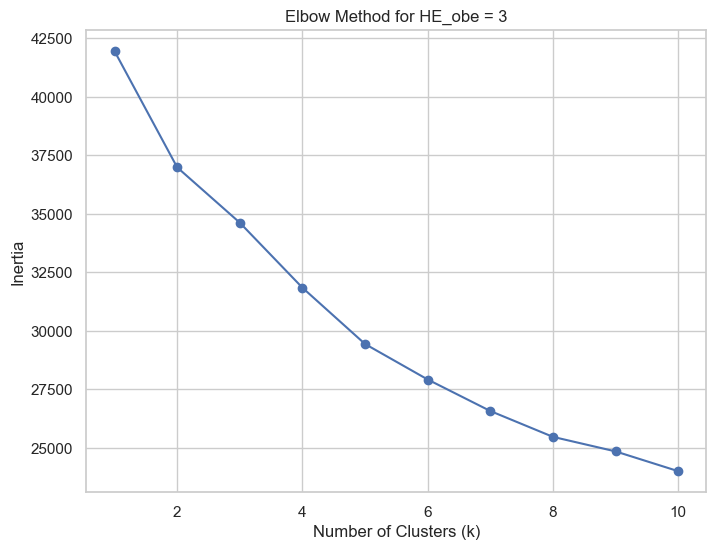

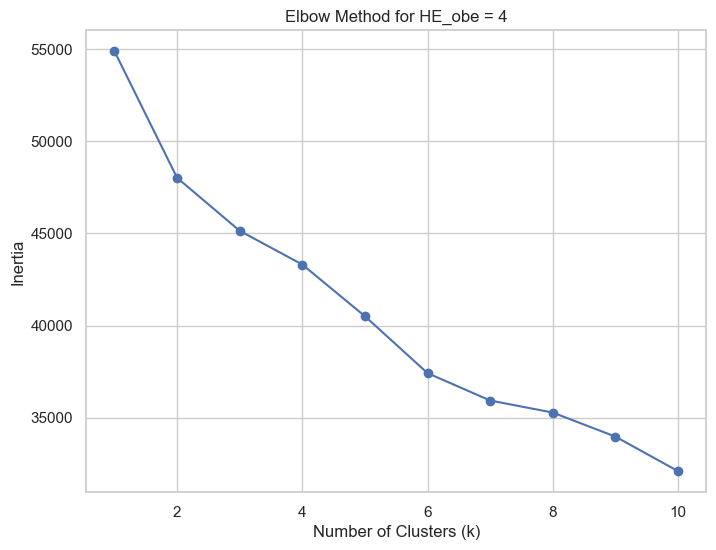

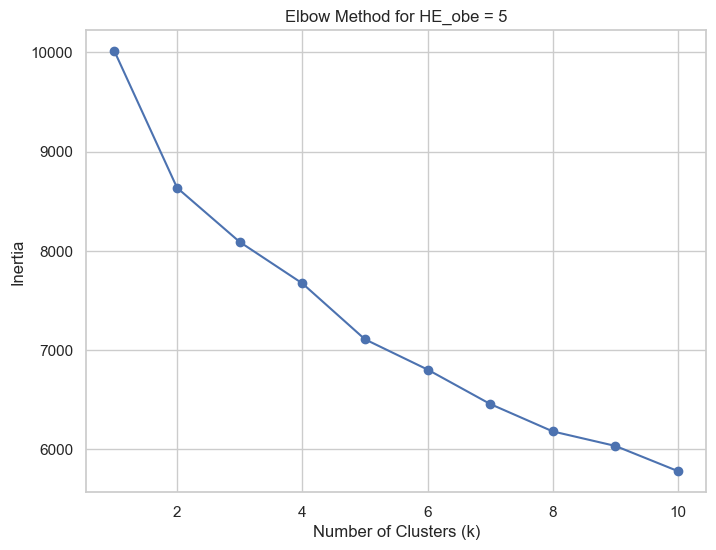

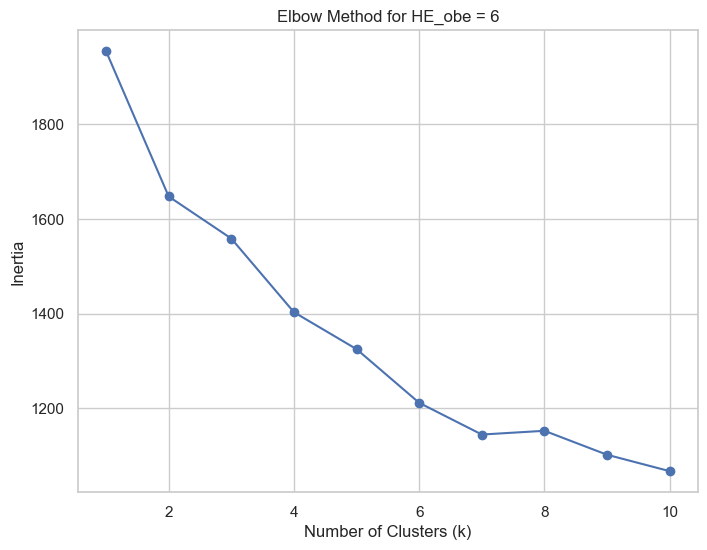

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (예: 1~10)
k_range = range(1, 11)

# 결과를 저장할 데이터프레임 준비
df_clustering['Cluster'] = np.nan

selected_cols = knn_columns + ["BD1_11","tobacco","BE5_1","LS_VEG1"]

for HE_obe_value in [1, 2, 3, 4, 5, 6]:
    # HE_obe 값에 해당하는 데이터 추출
    HE_obe_df = df_clustering[df_clustering['HE_obe'] == HE_obe_value][selected_cols].copy()

    if not HE_obe_df.empty:
        # 데이터 표준화
        scaled_df = scaler.fit_transform(HE_obe_df)

        # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산
        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, inertias, marker='o')
        plt.title(f'Elbow Method for HE_obe = {HE_obe_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()

        # 최적 k 선택 (예: 관성 감소율 기반)
        # 여기서는 수동으로 플롯을 보고 k를 선택하거나, 자동화된 방법을 사용할 수 있음
        # 예: 관성 감소율이 완만해지는 k를 선택 (임시로 k=3으로 설정, 실제로는 플롯 확인 후 결정)
        optimal_k = 3  # TODO: 엘보우 플롯을 보고 직접 선택하거나 자동화 필요

        # 최적 k로 K-means 군집화 수행
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(scaled_df)

        # 클러스터 결과 저장
        df_clustering.loc[HE_obe_df.index, 'Cluster'] = clusters


--- Processing HE_obe = 1 with k = 3 ---
Silhouette Score for HE_obe = 1 (k=3): 0.1114
Cluster Characteristics (Mean values for HE_obe = 1, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레         혈당     총 콜레스테롤  \
New_Cluster                                                                     
0                105.495319       66.729362  64.654638  88.329362  190.771064   
1                114.843609       71.255639  69.975940  96.679699  163.966917   
2                122.803883       75.706796  62.961748  94.800000  190.518447   

             HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  크레아티닌 (신장 기능 지표)  \
New_Cluster                                                                 
0                       71.688511            111.700426          0.672153   
1                       62.427068             91.879699          0.860391   
2                       75.060194            105.867961          0.703883   

             AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)         체

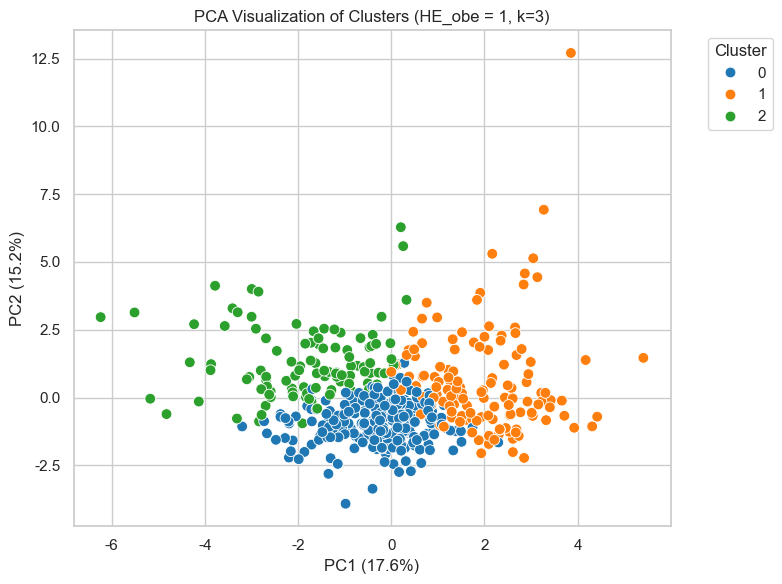


--- Processing HE_obe = 2 with k = 3 ---
Silhouette Score for HE_obe = 2 (k=3): 0.1231
Cluster Characteristics (Mean values for HE_obe = 2, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레          혈당  \
New_Cluster                                                          
0                132.176976       79.156529  77.694433  102.106701   
1                106.755829       67.925015  71.327053   90.947862   
2                120.365668       74.634980  81.320615  101.432713   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            189.140034             60.392612            113.475945   
1            192.194845             68.658465            114.808084   
2            175.937166             54.715789            105.758866   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                                             


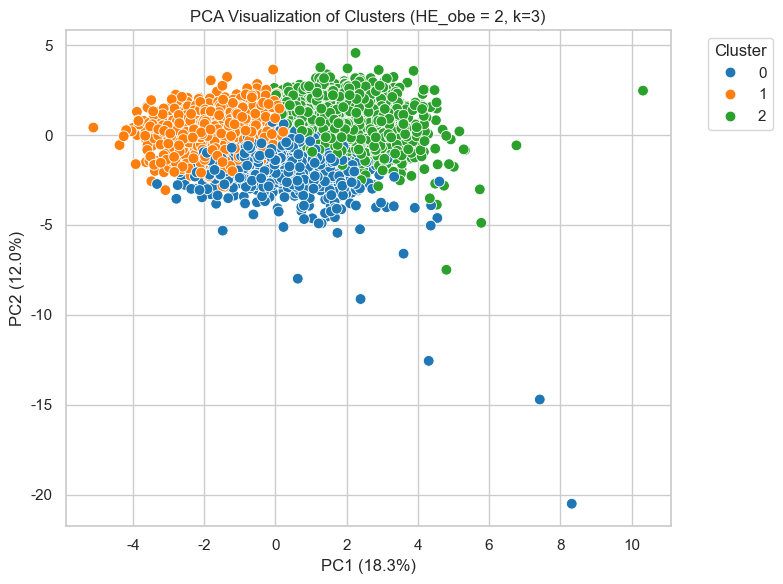


--- Processing HE_obe = 3 with k = 3 ---
Silhouette Score for HE_obe = 3 (k=3): 0.1118
Cluster Characteristics (Mean values for HE_obe = 3, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레          혈당  \
New_Cluster                                                          
0                127.810904       74.901578  85.993802  111.614347   
1                117.307403       73.315801  81.041348   94.800000   
2                125.366051       78.698845  87.541339  100.433487   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            149.946628             53.072597             80.547489   
1            209.296133             62.065856            133.366630   
2            194.794919             51.457737            122.671594   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                                             


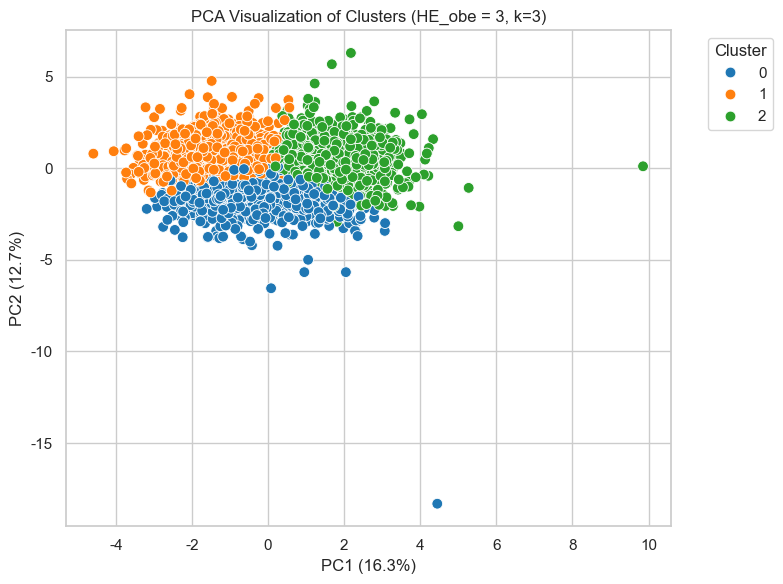


--- Processing HE_obe = 4 with k = 2 ---
Silhouette Score for HE_obe = 4 (k=2): 0.1343
Cluster Characteristics (Mean values for HE_obe = 4, k=2):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)       허리둘레          혈당  \
New_Cluster                                                          
0                128.256585       80.056963  94.736131  108.431758   
1                124.536137       74.861182  88.595637  102.805728   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            188.792439             47.837051            117.072086   
1            183.531140             55.738574            111.203656   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                                             
0                    0.940158           26.636547           31.937492   
1                    0.717205           22.092992           20.41011

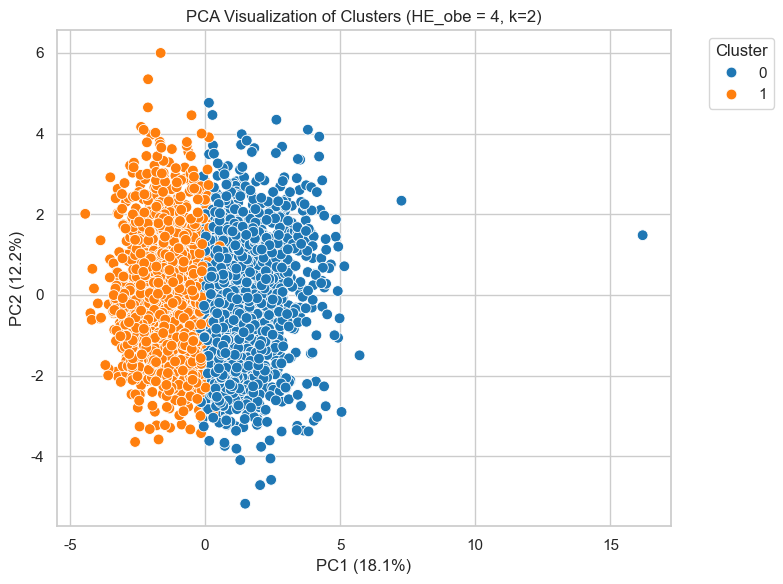


--- Processing HE_obe = 5 with k = 3 ---
Silhouette Score for HE_obe = 5 (k=3): 0.1384
Cluster Characteristics (Mean values for HE_obe = 5, k=3):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)        허리둘레          혈당  \
New_Cluster                                                           
0                132.923077       83.346154  104.259231  115.538462   
1                126.892086       79.573381  105.429496  112.495683   
2                127.266667       76.823158   98.447158  104.948772   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            233.423077             48.115385            155.038462   
1            185.857554             44.087050            118.033094   
2            184.571930             55.114386            112.027368   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                                         

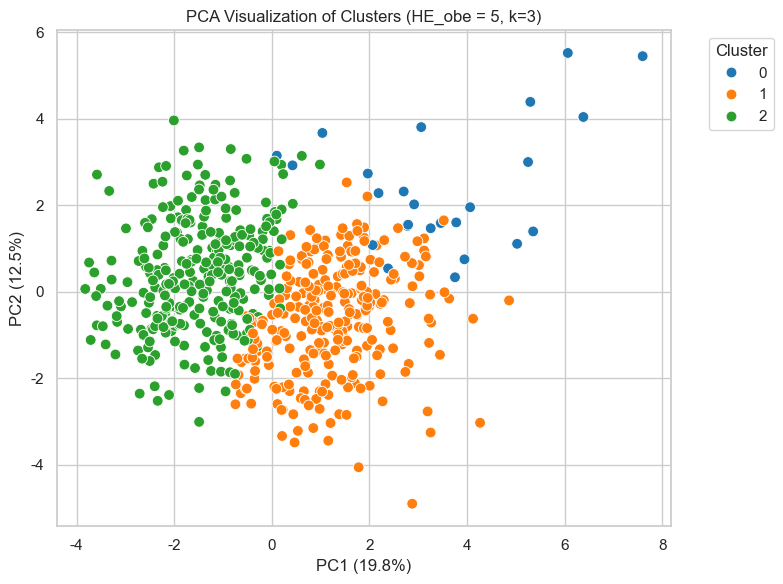


--- Processing HE_obe = 6 with k = 2 ---
Silhouette Score for HE_obe = 6 (k=2): 0.1485
Cluster Characteristics (Mean values for HE_obe = 6, k=2):
             수축기 혈압 (최고 혈압)  이완기 혈압 (최저 혈압)        허리둘레          혈당  \
New_Cluster                                                           
0                136.779661       85.355932  115.567458  102.779661   
1                127.982143       77.007143  107.569643  106.260714   

                총 콜레스테롤  HDL 콜레스테롤 (좋은 콜레스테롤)  LDL 콜레스테롤 (나쁜 콜레스테롤)  \
New_Cluster                                                           
0            200.284746             45.881356            129.528814   
1            177.192857             53.907143            106.960714   

             크레아티닌 (신장 기능 지표)  AST (간 기능 검사, GOT)  ALT (간 기능 검사, GPT)  \
New_Cluster                                                             
0                    0.900712           31.535593           50.776271   
1                    0.663679           22.785714           24.4

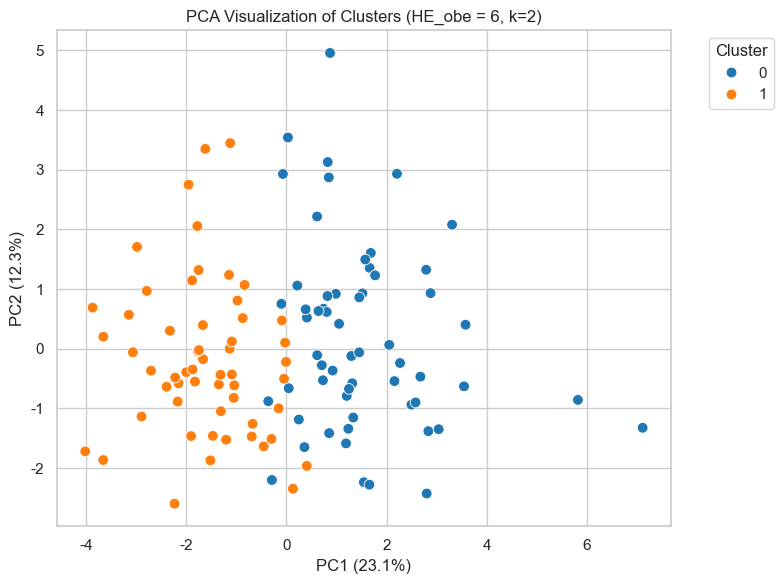

In [139]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd # pandas 필요
import matplotlib.pyplot as plt # matplotlib 필요
from sklearn.cluster import KMeans # KMeans 필요
# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
from sklearn.metrics import silhouette_score


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량',
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도'
}

# 시각화용 설정
sns.set(style="whitegrid")

# HE_obe 별로 반복
for HE_obe_value, optimal_k in zip([1, 2, 3, 4, 5, 6], [3, 3, 3, 2, 3, 2]):
    print(f"\n--- Processing HE_obe = {HE_obe_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함 (예: selected_cols = ['HE_sbp1', '...', 'LS_VEG1'])
    # df_clustering는 이전에 로드/처리되어 있어야 함
    # scaler는 이전에 fit 되어 있어야 함
    HE_obe_df = df_clustering[df_clustering['HE_obe'] == HE_obe_value][selected_cols].copy()
    # 이 변수는 현재 코드 플로우에서 직접 사용되지 않습니다. (기존 클러스터 라벨)
    # cluster_labels = df_clustering[df_clustering['HE_HP'] == HE_obe_value]['Cluster']


    if not HE_obe_df.empty:
        # 표준화
        scaled_df = scaler.fit_transform(HE_obe_df)

        # ====== 여기에서 optimal_k 값을 사용하여 클러스터링 수행 ======
        # K-Means 예시
        # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================
        if optimal_k > 1 and scaled_df.shape[0] > 1: # 데이터 포인트가 1개보다 많아야 계산 가능
                silhouette_avg = silhouette_score(scaled_df, new_cluster_labels)
                print(f"Silhouette Score for HE_obe = {HE_obe_value} (k={optimal_k}): {silhouette_avg:.4f}")
        else:
            if optimal_k <= 1:
                print(f"Silhouette Score cannot be calculated for k = {optimal_k} (must be > 1).")
            else: # scaled_df.shape[0] <= 1
                 print(f"Silhouette Score cannot be calculated for HE_obe = {HE_obe_value}: Insufficient data points ({scaled_df.shape[0]}).")

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 새로 생성된 클러스터 라벨 추가
        # 인덱스가 맞아야 함 (위에서 같은 필터링 기준으로 슬라이싱했으므로 일치한다고 가정)
        HE_obe_df_with_labels = HE_obe_df.copy() # 원본 HE_obe_df 변경 방지를 위해 복사
        HE_obe_df_with_labels['New_Cluster'] = new_cluster_labels

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = HE_obe_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_obe = {HE_obe_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 new_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = new_cluster_labels

        # PCA 2차원 축소
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df)

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 새로 생성된 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        plt.title(f'PCA Visualization of Clusters (HE_obe = {HE_obe_value}, k={optimal_k})') # 제목에 k값 추가
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()